In [1]:
%%capture
!pip install pyarrow
!pip install awswrangler
!pip install Pyathena
!pip install geopandas
!pip install contextily
!pip install geomath
!pip install folium
!pip install mplleaflet
!pip install geojson
!pip install transformers
!pip3 install torch torchvision torchaudio
!pip install xformers
!pip install dask

In [6]:
import dask

In [2]:
import torch
import pandas as pd
from transformers import pipeline
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [4]:
x = pd.read_parquet('s3://ds-intern-vlad-817187305846-eu-west-1/tdl_test/full_data_1.parquet')

In [5]:
x

,listing_id,listing_local_authority,price,price_band,bullets,short_description,long_description,uprn,longitude,latitude,search_clicks
0,63715152,Hounslow,259950.0,"£250,001 - £375,000","Modern apartment,Two bedrooms,En-suite to main...",This well presented two bedroom apartment loca...,None,10001265111,-0.411474,51.444466,8.0
1,61092077,Hounslow,255000.0,"£250,001 - £375,000","Apartment,Two Bedrooms,Family Bathroom & en-su...",Presented to the market this two bedroom fifth...,None,10001265111,-0.411474,51.444466,7.0
2,61092077,Hounslow,265000.0,"£250,001 - £375,000","Apartment,Two Bedrooms,Family Bathroom & en-su...",Presented to the market this two bedroom fifth...,None,10001265111,-0.411474,51.444466,5.0
3,63741959,Hammersmith and Fulham,550000.0,"£500,001 - £700,000",,"Beauclerc Road, London W6<BR><BR>A naturally b...",None,34013076,-0.229778,51.499695,2.0
4,56879041,Barking and Dagenham,240000.0,"£125,001 - £250,000",,"*Guide Price &pound;240,000 - &pound;260,000*<...",None,10002167063,0.139047,51.571821,3.0
...,...,...,...,...,...,...,...,...,...,...,...
140814,64502462,Hounslow,285000.0,"£250,001 - £375,000","First Floor Maisonette,2 Bedrooms,Offered With...",OFFERED WITH NO CHAIN. We are pleased to bring...,None,100022287081,-0.371130,51.450828,0.0
140815,61858500,Brent,325000.0,"£250,001 - £375,000","TWO BEDROOMS,OPEN PLAN KITCHEN AND LOUNGE,NEW ...",<p>NO UPPER CHAIN...</p><p>Located on a popula...,<p>NO UPPER CHAIN...</p><p>Located on a popula...,202118848,-0.242007,51.537954,0.0
140816,61858500,Brent,350000.0,"£250,001 - £375,000","TWO BEDROOMS,OPEN PLAN KITCHEN AND LOUNGE,NEW ...",<p>NO UPPER CHAIN...</p><p>Located on a popula...,<p>NO UPPER CHAIN...</p><p>Located on a popula...,202118848,-0.242007,51.537954,1.0
140817,62819533,Barnet,1500000.0,"£925,001 - £1,500,000",,A beautifully appointed first floor three bedr...,None,207023666,-0.173821,51.665935,0.0


In [9]:
geometry = [Point(xy) for xy in zip(x['longitude'], x['latitude'])]
test = gpd.GeoDataFrame(x, geometry = geometry)#gpd.points_from_xy(x.longitude, x.latitude))
test = GeoDataFrame(test, geometry='geometry')#, crs = 3395)
test = test.set_crs("EPSG:4326")

In [3]:
df = pd.read_csv('London_Neighbourhoods.csv')
df = df.drop(df.iloc[:, 6:11], axis =1)

In [4]:
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,20,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",20,TQ205805
2,Addington,Croydon,CROYDON,CR0,20,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,20,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",20,TQ478728
...,...,...,...,...,...,...
527,Woolwich,Greenwich,LONDON,SE18,20,TQ435795
528,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,20,TQ225655
529,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,20,TQ225815
530,Yeading,Hillingdon,HAYES,UB4,20,TQ115825


In [11]:
df = pd.DataFrame(df)

# this removes all the values within brackets
df['Location'] = df['Location'].str.replace(r"\(.*\)","", regex = True)
# this removes all leading/trailing white spaces
df['Location'] = df['Location'].str.strip()

In [14]:
full_neigh = df.Location.to_list()

In [15]:
borough_neighborhoods = {}
for index, row in df.iterrows():
    location = row['Location']
    boroughs = row['London borough'].split(',')

    for borough in boroughs:
        borough = borough.strip()  # Remove any leading/trailing spaces
        if borough not in borough_neighborhoods:
            borough_neighborhoods[borough] = []
        borough_neighborhoods[borough].append(location)

for borough, neighborhoods in borough_neighborhoods.items():
    borough_neighborhoods[borough] = sorted(neighborhoods)


In [16]:
# now subsetting the data to individual boroughs

# Create a dictionary to store borough names and their corresponding dataframes
borough_dataframes = {}

# Loop through the unique boroughs in the "listing_local_authority" column
for borough in test['listing_local_authority'].unique():
    # Create a subset dataframe for the current borough
    subset_df = test[test['listing_local_authority'] == borough].copy()
    
    # Add the subset dataframe to the dictionary with the borough name as the key
    borough_dataframes[borough] = subset_df.reset_index()

# Now, the 'borough_dataframes' dictionary contains borough names as keys and their corresponding dataframes as values
# You can access the dataframes for each borough directly from the dictionary


In [17]:
common_keys = set(borough_neighborhoods.keys()).intersection(borough_dataframes.keys())

In [24]:
years = []
for df in borough_dataframes:
    years += [borough_dataframes[df].short_description.size]
    
# we see that all the boroughs have a high number of values, enough for statistical significance
#years

In [18]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      multi_label=True,
                      device=0) #uses gpu (maximum available)

In [19]:
%%time

import pandas as pd
from transformers import pipeline

def classify_strings(strings, candidate_labels,key, threshold=0.9):
    # Initialize the zero-shot classification model
    # classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", multi_label=True, device=0)

    # Create an empty list to store the results
    results_list = []

    # Iterate over the strings and classify each one
    for string in strings.short_description.to_list():
        # Perform zero-shot classification
        result = classifier(string, candidate_labels)

        # Extract the labels and scores from the result
        labels = result["labels"]
        scores = result["scores"]

        # Filter the labels and scores based on the score threshold
        filtered_labels = [label for label, score in zip(labels, scores) if score > threshold]
        filtered_scores = [score for score in scores if score > threshold]

        # Create a dictionary for the current result
        result_dict = {"String": string, "Labels": filtered_labels, "Scores": filtered_scores}

        # Append the result dictionary to the list
        results_list.append(result_dict)

    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(results_list)
    # Remove rows without any result
    results_df = results_df[results_df["Labels"].apply(lambda x: len(x) > 0)]
    # Reset the index of the DataFrame
    results_df = results_df.reset_index()
    
    results_df = pd.merge(results_df, strings['geometry'], left_on='index', right_index=True, how='left')
    results_df['Labels'] = results_df['Labels'].astype('string')
    #results_df = results_df.drop(columns =['Unnamed: 0'])
    #results_df = gpd.GeoDataFrame(results_df, crs='epsg:4326')
    #results_df['latitude'] = results_df.geometry.y
    #results_df['longitude'] = results_df.geometry.x
    # Save the resulting dataframe to a file
    output_file = f"s3://ds-intern-vlad-817187305846-eu-west-1/data/KDE_full_results_v2/{key}_result.csv"  # Customize the file name as needed
    results_df.to_csv(output_file, index=False)
    print("saved to csv")

    return results_df

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 18.1 µs


In [ ]:
%%time
Barking = classify_strings(borough_dataframes['Barking and Dagenham'],
                                 borough_neighborhoods['Barking and Dagenham'],
                                 key='Barking and Dagenham')

#results_final['Labels']
#Tower_Hamlets['Labels'] = Tower_Hamlets['Labels'].astype('string')
#Tower_Hamlets.to_parquet('s3://ds-intern-vlad-817187305846-eu-west-1/data/KDE_full_results_v2/Tower_Hamlets.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 11min 26s, sys: 216 ms, total: 11min 26s
Wall time: 11min 26s


In [20]:
pd.read_csv('s3://ds-intern-vlad-817187305846-eu-west-1/data/KDE_full_results_v2/Barking and Dagenham_result.csv')

,index,String,Labels,Scores,geometry
0,3,"*** GUIDE PRICE &pound;375,000 - &pound;400,00...",['Dagenham'],[0.9214153289794922],POINT (0.1536758 51.5390264)
1,9,Attractive three bedroom house situated within...,['Marks Gate'],[0.9883324503898621],POINT (0.1372264 51.5843815)
2,11,&bull; NO ONWARD CHAIN<br />&bull; THREE BEDRO...,"['Chadwell Heath', 'Dagenham']","[0.9837203025817871, 0.9438179731369019]",POINT (0.1536758 51.5390264)
3,12,This two bedroom terraced house set in quiet p...,['Dagenham'],[0.9958459734916687],POINT (0.1502766 51.5587024)
4,13,Located just a few minutes walk from Dagenham ...,['Dagenham'],[0.9647766947746277],POINT (0.1426872 51.5467097)
...,...,...,...,...,...
699,2298,Tom Ashwood is delighted to offer to the marke...,['Barking'],[0.9595316052436829],POINT (0.079518 51.5420641)
700,2299,This wonderful 2 bedroom end of terrace starte...,['Barking'],[0.9543311595916748],POINT (0.1191863 51.5261022)
701,2300,This wonderful 2 bedroom end of terrace starte...,['Barking'],[0.9543311595916748],POINT (0.1191863 51.5261022)
702,2311,Ashton Estate Agents are pleased to offer for ...,['Dagenham'],[0.992985725402832],POINT (0.1344576 51.5554747)


In [58]:
Tower_Hamlets = gpd.GeoDataFrame(Tower_Hamlets, crs='epsg:4326')
Tower_Hamlets['latitude'] = Tower_Hamlets.geometry.y
Tower_Hamlets['longitude'] = Tower_Hamlets.geometry.x

In [65]:
#full_neigh = df.Location.to_list()
new_dfs = {}

test2 = Tower_Hamlets[['String','Labels','geometry','Scores', 'latitude', 'longitude']]

# Iterate over the word list
for word in full_neigh:
    # Subset the DataFrame for the current word
    subset_df = test2[test2['Labels'].str.contains(word)]
    # Store the subset DataFrame in the dictionary
    new_dfs[word] = subset_df
    
filtered_dict = {k: v for (k, v) in new_dfs.items() if len(v) > 2} 

/tmp/ipykernel_18729/3742105560.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  subset_df = test2[test2['Labels'].str.contains(word)]


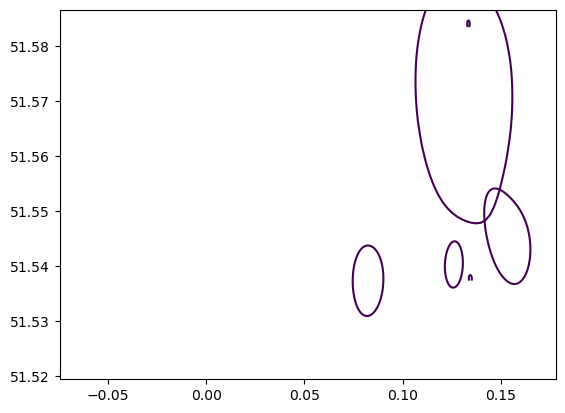

In [66]:
import folium
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping
from sklearn.neighbors import KernelDensity

# Define the bandwidth for KDE
bandwidth = 0.01

# Load the shapefile using GeoPandas
shapefile_path = "London_Borough_Excluding_MHW.shp"
gdf = gpd.read_file(shapefile_path)

# Create a folium map
m = folium.Map(location=[Tower_Hamlets.geometry.y.mean(),
                         Tower_Hamlets.geometry.x.mean()], zoom_start=10)

folium.GeoJson(gdf,
               name='Shapefile Layer',
               style_function=lambda x: {'fillOpacity': 0,'fillColor': 'blue', 'color': 'blue'},  # Customize the style
               tooltip='Shapefile Layer'
              ).add_to(m)

# Loop through the dictionary of DataFrames
for df_name, df in filtered_dict.items():
    # Create an empty feature group for the KDE contour
    kde_fg = folium.FeatureGroup(name=df_name, show=True, tooltip=df_name)

    #df['latitude'] = df.geometry.y
    #df['longitude'] = df.geometry.x
    # Extract the latitude and longitude values
    data = df[['latitude', 'longitude']].values

    # Fit the KDE model
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(data)

    # Generate grid points for evaluation
    lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
    lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
    lat_grid, lon_grid = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
    grid_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    # Evaluate the KDE on grid points
    log_density = kde.score_samples(grid_points)

    # Convert log density to probability density
    density = np.exp(log_density)

    # Reshape density to match grid shape
    density = density.reshape(lat_grid.shape)

    # Find contours of high density regions
    contours = plt.contour(lon_grid, lat_grid, density, levels=[np.percentile(density, 90)])

    # Loop through the contour paths and create polygons
    for path in contours.collections[0].get_paths():
        polygon = Polygon(path.vertices)

        # Create a GeoDataFrame from the polygon
        gdf = gpd.GeoDataFrame(geometry=[polygon])

        # Set the CRS to WGS84
        gdf.crs = "EPSG:4326"

        # Convert the GeoDataFrame to GeoJSON
        geojson = gdf.to_json()

        # Create a folium GeoJson object from the GeoJSON
        geojson_obj = folium.GeoJson(geojson, name=df_name, show=False, tooltip=df_name)

        # Add the GeoJson object to the KDE feature group
        geojson_obj.add_to(kde_fg)

    # Add the KDE feature group to the map
    kde_fg.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m);

In [67]:
m

In [28]:
sorted(common_keys)

['Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'City of London',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [ ]:
%%time
Barnet = classify_strings(borough_dataframes['Barnet'],
                                 borough_neighborhoods['Barnet'],
                                 key='Barnet')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [22]:
pd.read_csv('s3://ds-intern-vlad-817187305846-eu-west-1/data/KDE_full_results_v2/Barnet_result.csv')

,index,String,Labels,Scores,geometry
0,10,The Property Shop is proud to offer this immac...,['Edgware'],[0.9936020970344543],POINT (-0.2766248 51.6275696)
1,11,<p>A post war ex-local authority first floor f...,['Cricklewood'],[0.9277420043945312],POINT (-0.226745 51.5603403)
2,15,Located in Hendon we have a great opportunity ...,['Hendon'],[0.9976322054862976],POINT (-0.2336644 51.5931393)
3,16,Located in Hendon we have a great opportunity ...,['Hendon'],[0.9976322054862976],POINT (-0.2336644 51.5931393)
4,19,The first time on the market in over 50 years!...,['Totteridge'],[0.9832644462585449],POINT (-0.1866843 51.624466)
...,...,...,...,...,...
2190,8530,**Parking Included** A modern 1-bedroom apartm...,['Colindale'],[0.9789481163024902],POINT (-0.2446904 51.5936181)
2191,8531,We are pleased to present a collection of newl...,['North Finchley'],[0.9103969931602478],POINT (-0.1762115 51.620774)
2192,8532,Modern and spacious two bedroom penthouse apar...,['Colindale'],[0.9530242085456848],POINT (-0.2519832 51.6006016)
2193,8533,Set on the 1st floor with lift access within t...,['Whetstone'],[0.9915952086448669],POINT (-0.1750158 51.6289171)


In [ ]:
%%time
Bexley = classify_strings(borough_dataframes['Bexley'],
                                 borough_neighborhoods['Bexley'],
                                 key='Bexley')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 1h 11min 3s, sys: 1.66 s, total: 1h 11min 5s
Wall time: 1h 11min 4s


In [ ]:
%%time
Brent = classify_strings(borough_dataframes['Brent'],
                                 borough_neighborhoods['Brent'],
                                 key='Brent')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 31min 24s, sys: 536 ms, total: 31min 24s
Wall time: 31min 24s


In [ ]:
%%time
Camden = classify_strings(borough_dataframes['Camden'],
                                 borough_neighborhoods['Camden'],
                                 key='Camden')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 30min 23s, sys: 708 ms, total: 30min 24s
Wall time: 30min 24s


In [ ]:
%%time
City = classify_strings(borough_dataframes['City of London'],
                                 borough_neighborhoods['City of London'],
                                 key='City of London')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 33.4 s, sys: 12 ms, total: 33.4 s
Wall time: 33.5 s


In [ ]:
%%time
Croydon = classify_strings(borough_dataframes['Croydon'],
                                 borough_neighborhoods['Croydon'],
                                 key='Croydon')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 1h 39min 29s, sys: 5.06 s, total: 1h 39min 34s
Wall time: 1h 39min 33s


In [ ]:
%%time
Ealing = classify_strings(borough_dataframes['Ealing'],
                                 borough_neighborhoods['Ealing'],
                                 key='Ealing')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
%%time
Enfield = classify_strings(borough_dataframes['Enfield'],
                                 borough_neighborhoods['Enfield'],
                                 key='Enfield')

In [ ]:
%%time
Greenwich = classify_strings(borough_dataframes['Greenwich'],
                                 borough_neighborhoods['Greenwich'],
                                 key='Greenwich')

In [ ]:
%%time
Hackney = classify_strings(borough_dataframes['Hackney'],
                                 borough_neighborhoods['Hackney'],
                                 key='Hackney')

In [29]:
%%time
Hammersmith = classify_strings(borough_dataframes['Hammersmith and Fulham'],
                                 borough_neighborhoods['Hammersmith and Fulham'],
                                 key='Hammersmtih and Fulham')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 24min 48s, sys: 623 ms, total: 24min 48s
Wall time: 24min 48s


In [ ]:
%%time
Haringey = classify_strings(borough_dataframes['Haringey'],
                                 borough_neighborhoods['Haringey'],
                                 key='Haringey')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
%%time
Harrow = classify_strings(borough_dataframes['Harrow'],
                                 borough_neighborhoods['Harrow'],
                                 key='Harrow')

In [ ]:
%%time
Havering = classify_strings(borough_dataframes['Havering'],
                                 borough_neighborhoods['Havering'],
                                 key='Havering')

In [ ]:
%%time
Hillingdon = classify_strings(borough_dataframes['Hillingdon'],
                                 borough_neighborhoods['Hillingdon'],
                                 key='Hillingdon')

In [ ]:
%%time
Hounslow = classify_strings(borough_dataframes['Hounslow'],
                                 borough_neighborhoods['Hounslow'],
                                 key='Hounslow')

In [ ]:
%%time
Islington = classify_strings(borough_dataframes['Islington'],
                                 borough_neighborhoods['Islington'],
                                 key='Islington')

In [ ]:
%%time
Kensington = classify_strings(borough_dataframes['Kensington and Chelsea'],
                                 borough_neighborhoods['Kensington and Chelsea'],
                                 key='Kensington and Chelsea')

In [ ]:
%%time
Kingston = classify_strings(borough_dataframes['Kingston upon Thames'],
                                 borough_neighborhoods['Kingston upon Thames'],
                                 key='Kingston upon Thames')

In [ ]:
%%time
Lambeth = classify_strings(borough_dataframes['Lambeth'],
                                 borough_neighborhoods['Lambeth'],
                                 key='Lambeth')

In [ ]:
%%time
Lewisham = classify_strings(borough_dataframes['Lewisham'],
                                 borough_neighborhoods['Lewisham'],
                                 key='Lewisham')

In [ ]:
%%time
Merton = classify_strings(borough_dataframes['Merton'],
                                 borough_neighborhoods['Merton'],
                                 key='Merton')

In [ ]:
%%time
Newham = classify_strings(borough_dataframes['Newham'],
                                 borough_neighborhoods['Newham'],
                                 key='Newham')

In [ ]:
%%time
Redbridge = classify_strings(borough_dataframes['Redbridge'],
                                 borough_neighborhoods['Redbridge'],
                                 key='Redbridge')

In [ ]:
%%time
Richmond = classify_strings(borough_dataframes['Richmond upon Thames'],
                                 borough_neighborhoods['Richmond upon Thames'],
                                 key='Richmond upon Thames')

In [ ]:
%%time
Southwark = classify_strings(borough_dataframes['Southwark'],
                                 borough_neighborhoods['Southwark'],
                                 key='Southwark')

In [ ]:
%%time
Sutton = classify_strings(borough_dataframes['Sutton'],
                                 borough_neighborhoods['Sutton'],
                                 key='Sutton')

In [ ]:
%%time
TH = classify_strings(borough_dataframes['Tower Hamlets'],
                                 borough_neighborhoods['Tower Hamlets'],
                                 key='Tower Hamlets')

In [20]:
%%time
Waltham = classify_strings(borough_dataframes['Waltham Forest'],
                                 borough_neighborhoods['Waltham Forest'],
                                 key='Waltham Forest')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 20min 19s, sys: 16.5 s, total: 20min 36s
Wall time: 20min 36s


In [ ]:
%%time
Wandsworth = classify_strings(borough_dataframes['Wandsworth'],
                                 borough_neighborhoods['Wandsworth'],
                                 key='Wandsworth')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 33min 3s, sys: 472 ms, total: 33min 4s
Wall time: 33min 4s


In [ ]:
%%time
Westminster = classify_strings(borough_dataframes['Westminster'],
                                 borough_neighborhoods['Westminster'],
                                 key='Westminster')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


saved to csv
CPU times: user 1h 4min 46s, sys: 1.12 s, total: 1h 4min 47s
Wall time: 1h 4min 47s


In [ ]:
%%time
Bromley = classify_strings(borough_dataframes['Bromley'],
                                 borough_neighborhoods['Bromley'],
                                 key='Bromley')